# Exercise 1: t-SNE

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically.
* Failure to comply with the following instructions will result in a significant penalty.
* Appeals regarding your failure to read these instructions will be denied.
* Kindly reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone.
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions:

### *** 205985815 ***
### *** 806614 ***
---
---


In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
from scipy.spatial import distance_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing



# your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use this cell and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation

In [ ]:
class CustomTSNE:
    def __init__(self, perplexity=30.0, n_components=2, n_iter=1000, learning_rate=200.0, max_iter_perplexity = 250, err = 1e-5, beta = 0.5):
        self.perplexity = perplexity
        self.n_components = n_components
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        # Note: You may add more attributes
        self.max_iter_perplexity = max_iter_perplexity
        self.err = err
        self.loss = []
        self.beta = beta
        self.scaler = preprocessing.StandardScaler()

    def get_high_dim_pairwise_affinities(self, X, new_data=None):
        data = X if new_data is None else new_data

        i_size = X.shape[0] if new_data is None else new_data.shape[0]
        j_size = X.shape[0]


        high_dim_similarity = np.zeros((i_size,j_size))

        for i in range(i_size):
          # find variance search
          var_min, var_max = 1e-10, None
          while True:
            if var_max is not None:
              variance = np.sqrt((var_min + var_max) / 2)
            else:
              variance = np.sqrt(var_min * 2)

            # Calculate the conditional distribution for sample i
            neumerator = np.exp(-1 * (np.linalg.norm(data[i] - X, axis=1) ** 2) / (2 * (variance** 2)))
            if new_data is None:
              neumerator[i] = 0
            denomenator = np.sum(neumerator) + 1e-10
            prob_distribution_i = neumerator / denomenator

            # check if current distribution gives required perplexity if not update variance
            entropy = -np.sum(prob_distribution_i * np.log(prob_distribution_i + 1e-10))
            perplexity_curr = 2**entropy
            if (perplexity_curr) > self.perplexity:
              var_max = variance ** 2
            else:
              var_min = variance ** 2

            # if required perplexity is obtianed break out if loop and continue to finding low dimensional points
            if np.abs(perplexity_curr - self.perplexity) < self.err:
              high_dim_similarity[i, :] = prob_distribution_i
              break

        # make high_dim_similarity simetric, we omit the symmetrization step for new data points as mentioned in the paper
        if new_data is None:
          high_dim_similarity = (high_dim_similarity + high_dim_similarity.T) / (2 * i_size)

        return high_dim_similarity

    def get_low_dim_pairwise_affinities(self, Y, new_data=None):

        i_size = Y.shape[0]if new_data is None else new_data.shape[0]
        j_size = Y.shape[0]

        low_dim_similarity = np.zeros((i_size,j_size))
        data = Y if new_data is None else new_data

        for i in range(i_size):
          distances = np.linalg.norm(data[i] - Y, axis=1)
          low_dim_similarity[i, :] = 1 / (1 + distances**2)
        if new_data is None:
          np.fill_diagonal(low_dim_similarity, 0)
        low_dim_similarity /= low_dim_similarity.sum() + 1e-10

        return low_dim_similarity


    def calculate_kl_divergence(self, high_dim_similarity, low_dim_similarity):
        return np.sum(high_dim_similarity * np.log((high_dim_similarity + 1e-10) / (low_dim_similarity + 1e-10)))


    def calculate_gradient(self, high_dim_similarity, low_dim_similarity, Y, new_data=None):
        data = Y if new_data is None else new_data
        n = data.shape[0]

        pq_diff = high_dim_similarity - low_dim_similarity
        gradient = np.zeros_like(data)
        for i in range(n):
            # calulate the 3 terms needed for gradient
            # using formula form lectuer notes not hw
            t_3 = data[i] - Y
            t_1 = np.array([(high_dim_similarity[i, :] - low_dim_similarity[i, :])])
            t_2 = np.array([(1 + np.linalg.norm(t_3, axis=1)) ** (-1)])

            # set the gradient of cost function with respect to yi
            gradient[i] = 4 * np.sum((t_1 * t_2).T * t_3, axis=0)

        return gradient

    def initialize_new_data(self, X_original, Y_original, X_new, k=5):
        from scipy.spatial import cKDTree
        # try k = num points/classes/2
        k = 9

        Y_new = np.zeros((X_new.shape[0], self.n_components))

        # init the tree with prevoius data from the high dimentional space
        tree = cKDTree(X_original)

        # find knn
        _, indices = tree.query(X_new, k=k)

        #  initialized to the median reference embedding position of its k nearest neighbors
        for i, neighbor_indices in enumerate(indices):
            Y_new[i] = np.median(Y_original[neighbor_indices], axis=0)

        return Y_new


    # Part 1: Implementing t-SNE
    def fit_transform(self, X):

        X = self.scaler.fit_transform(X)

        if isinstance(X, pd.DataFrame):
          X = X.values
        self.loss = []
        self.test_loss = []
        n = X.shape[0]
        Y = np.random.randn(n, self.n_components)*0.1
        Y_old = Y

        # Step 1: Compute pairwise affinities in the original space with a Gaussian distribution
        high_dim_similarity = self.get_high_dim_pairwise_affinities(X)

        # find points in low dimension and use gradient descent to update
        for _ in range(self.n_iter):
          # Step 2: Compute pairwise affinities in the low-dimensional space with a t-distribution
          # Your code here
          low_dim_similarity = self.get_low_dim_pairwise_affinities(Y)


          # Step 3: Compute the KL divergence as the loss function
          # compute loss
          self.loss.append(self.calculate_kl_divergence(high_dim_similarity, low_dim_similarity))

          # Step 4: Compute the gradient of the loss
          gradient = self.calculate_gradient(high_dim_similarity, low_dim_similarity, Y)


          # Step 5: Perform gradient descent to minimize the KL divergence
          # we use momentum gradient descent to update y
          if _ != 0:
            y_temp = Y
            Y = Y - (self.learning_rate * gradient) + self.beta*(Y_old - Y)
            Y_old = y_temp

          else:
            Y -= self.learning_rate * gradient

        return Y  # The 2D representation of the input data

    # Part 2: Transformation of New Data Points
    def transform(self, X_original, Y_original, X_new, learning_rate=None):

      X_new = self.scaler.transform(X_new)
      X_original = self.scaler.transform(X_original)

      if isinstance(X_original, pd.DataFrame):
        X_original = X_original.values
      if isinstance(Y_original, pd.DataFrame):
        Y_original = Y_original.values
      if isinstance(X_new, pd.DataFrame):
        X_new = X_new.values

      learning_rate = self.learning_rate if learning_rate is None else learning_rate
      n = X_original.shape[0]
      m = X_new.shape[0]

      # initialize new data position in low dimention space
      Y_new = self.initialize_new_data(X_original, Y_original, X_new)
      Y_old = Y_new

      high_dim_similarity = self.get_high_dim_pairwise_affinities(X=X_original, new_data=X_new)

      for _ in range(self.n_iter):
        # Step 2: Compute pairwise affinities in the low-dimensional space with a t-distribution
        # Your code here
        low_dim_similarity = self.get_low_dim_pairwise_affinities(Y_original, new_data=Y_new)


        # Step 3: Compute the KL divergence as the loss function
        # compute loss
        self.test_loss.append(self.calculate_kl_divergence(high_dim_similarity, low_dim_similarity))

        # Step 4: Compute the gradient of the loss
        gradient = self.calculate_gradient(high_dim_similarity, low_dim_similarity, Y_original, new_data=Y_new)


        # Step 5: Perform gradient descent to minimize the KL divergence
        # we use momentum gradient descent to update y
        if _ != 0:
          y_temp = Y_new
          Y_new = Y_new - (learning_rate * gradient) + self.beta*(Y_old - Y_new)
          Y_old = y_temp

        else:
          Y_new -= learning_rate * gradient


      return Y_new

    def get_train_loss(self):
      return self.loss


    def get_test_loss(self):
      return self.test_loss

# Load Data
Please Keep this cell unchanged
You may alter the dataset size during development but the final submission should include these exact preprocessing steps

In [ ]:
# Load MNIST data
N = 200
X, label = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X[:N]
label = label[:N]
X = X / 255.0  # Normalize data

np.random.seed(42)
# train_test_split
X_train, X_test, label_train, label_test = train_test_split(X, label, test_size=0.1)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# t-SNE implementation
Demonstrate your t-SNE implementation.
Add plots and figures if needed.
Please use this cell to describe your results and tests

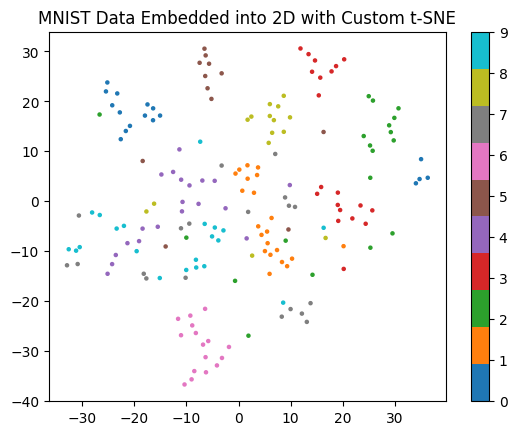

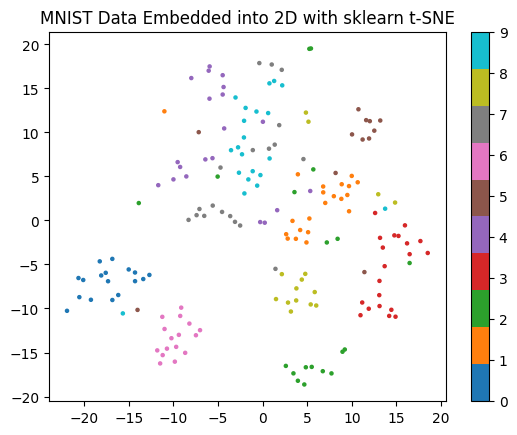

In [ ]:
# Run your custom t-SNE implementation
custom_tsne = CustomTSNE(n_iter=1000, n_components=2, perplexity=5, learning_rate=50, beta=0.5)
# custom_tsne = CustomTSNE(n_iter=10000, n_components=2, perplexity=N/7, learning_rate=1, beta=0.5)
custom_Y = custom_tsne.fit_transform(X_train)
# Run sklearn t-SNE

sk_tsne = TSNE(n_components=2, init='random', perplexity=N/10)
sk_Y = sk_tsne.fit_transform(X_train)

# Visualization of the result
plt.figure()
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')
plt.show()

plt.figure()
plt.scatter(sk_Y[:, 0], sk_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with sklearn t-SNE')
plt.show()

# t-SNE extension - mapping new samples
Unlike parametric models, t-SNE does not provide a straightforward way to transform new data because it lacks a fixed mathematical function (such as weights in neural networks) that can be applied to new instances. This issue is addressed in Maaten, 2009[https://link.springer.com/article/10.1007/s10994-021-06043-1#Equ1], which proposes a method to infer the embedding of new points based on the existing embedding

### Introduction to t-SNE for New Data Points

Unlike parametric models, t-SNE does not provide a straightforward way to transform new data because it lacks a fixed mathematical function (such as weights in neural networks) that can be applied to new instances. This issue is addressed in [Maaten, 2009](https://link.springer.com/article/10.1007/s10994-021-06043-1#Equ1), which proposes a method to infer the embedding of new points based on the existing embedding.

Our approach for incorporating new data points into an existing t-SNE embedding builds on the concept of utilizing KNN to anchor the new points in the transformed space.:

1. **Initialization of New Points in Low-Dimensional Space**:
   - Instead of initializing the coordinates of new points randomly, we base their initialization on the median location of their knn in the existing low-dimensional embedding. This heuristic approach helps in approximating a reasonable starting point, potentially leading to a more accurate embedding of new points.

2. **High/Low-Dimensional Similarity Calculation**:
   - We adapt the standard t-SNE formulation:

\begin{equation}
p_{j|i} = \frac{\exp\left(-\frac{1}{2}D(\mathbf{x}_i, \mathbf{v}_j)/\sigma_i^2\right)}
                {\sum_i \exp\left(-\frac{1}{2}D(\mathbf{x}_i, \mathbf{v}_j)/\sigma_i^2\right)}
\end{equation}


\begin{equation}
q_{j|i} = \frac{(1 + \|\mathbf{y}_i - \mathbf{w}_j\|^2)^{-1}}{\sum_i (1 + \|\mathbf{y}_i - \mathbf{w}_j\|^2)^{-1}}
\end{equation}



3. **Optimization**:
   - After initialization, the new points' embeddings are refined through further iterations of gradient descent, where the objective is to minimize the Kullback-Leibler divergence between the joint probabilities in the high-dimensional space and those in the low-dimensional space, therefor the new calculation of the gradient is:
     \begin{aligned} \frac{\partial C}{\partial {\mathbf {w}}_j} = 2 \sum _i \left( p_{j \mid i} - q_{j \mid i} \right) \left( {\mathbf {y}}_i - {\mathbf {w}}_j \right) \left( 1 + || {\mathbf {y}}_i - {\mathbf {w}}_j || ^2 \right) ^{-1} \end{aligned}


Text(0.5, 1.0, 'MNIST Data Embedded into 2D with Custom t-SNE')

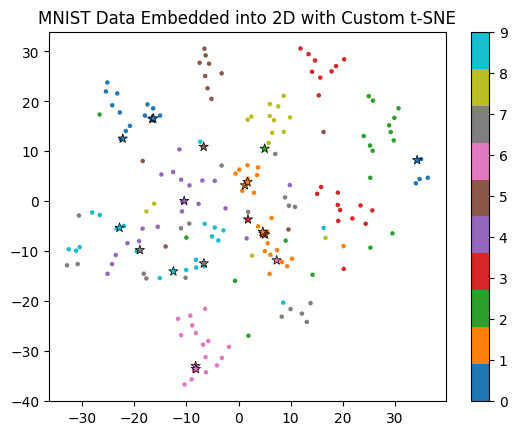

In [ ]:
# Transform new data
# custom_Y_new = custom_tsne.transform(X_train,custom_Y,X_test)
Y_new = custom_tsne.transform(X_train, custom_Y, X_test, learning_rate=0.1)

# Visualization of the result
plt.figure()
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.scatter(Y_new[:, 0], Y_new[:, 1], marker = '*', s=50, linewidths=0.5, edgecolors='k', c=label_test.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')

# Report

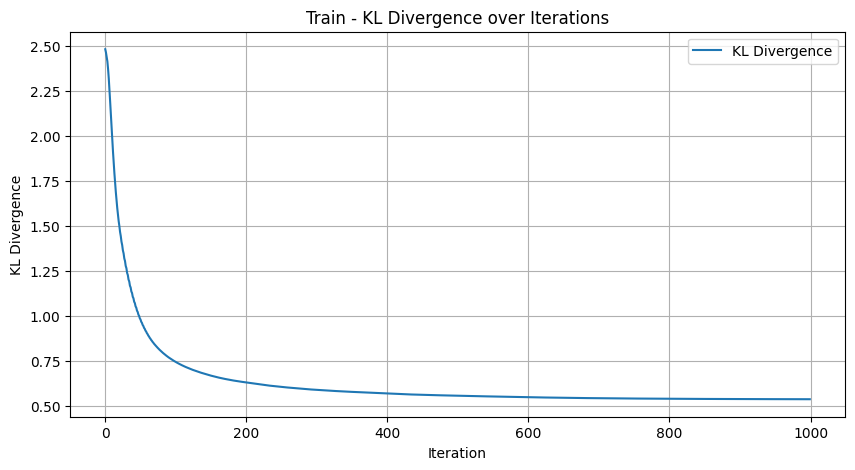

In [ ]:
# Transform new data
loss = custom_tsne.get_train_loss()
indexes = list(range(len(loss)))  # This creates a list of iteration indices, corrected from your original syntax

# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(indexes, loss, label='KL Divergence')
plt.title('Train - KL Divergence over Iterations')
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')
plt.legend()
plt.grid(True)
plt.show()

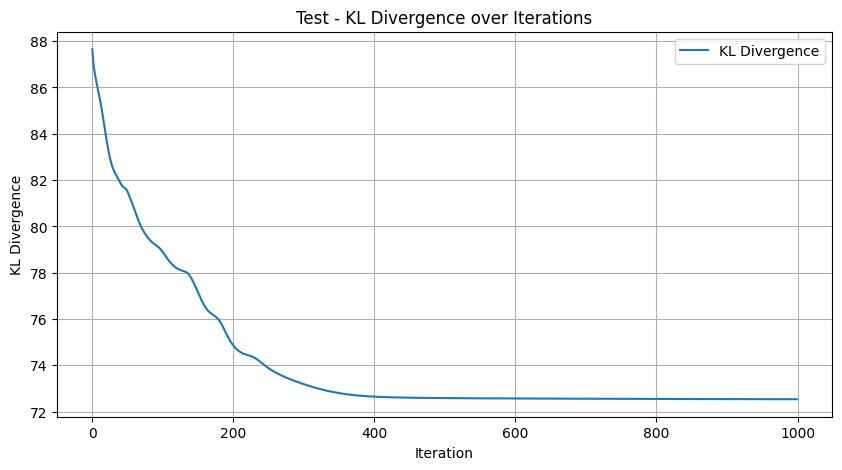

In [ ]:
# Transform new data
loss = custom_tsne.get_test_loss()
indexes = list(range(len(loss)))  # This creates a list of iteration indices, corrected from your original syntax

# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(indexes, loss, label='KL Divergence')
plt.title('Test - KL Divergence over Iterations')
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')
plt.legend()
plt.grid(True)
plt.show()

### performance measure using KNN [https://arxiv.org/pdf/2007.13487]
 In the paper kNN is utilized primarily to assess the classification accuracy of single-cell data across different batches after embedding them into a reference t-SNE space.
 KNN is being applied to the embedded space to see if cells cluster with others of the same type despite originating from different batches

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


# Train classifier on transformed training data
knn = KNeighborsClassifier()
knn.fit(custom_Y, label_train.astype(int))


# Predict and evaluate
predictions = knn.predict(Y_new)
print("Classification Report for Custom t-SNE:\n")
print(classification_report(label_test.astype(int), predictions))



Classification Report for Custom t-SNE:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.62      1.00      0.77         5
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.33      1.00      0.50         1
           5       0.00      0.00      0.00         1
           6       1.00      0.67      0.80         3
           7       0.00      0.00      0.00         2
           9       0.67      1.00      0.80         2

    accuracy                           0.70        20
   macro avg       0.40      0.52      0.43        20
weighted avg       0.59      0.70      0.62        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
label_train

124    1
16     2
148    7
93     6
65     5
      ..
106    6
14     1
92     4
179    3
102    1
Name: class, Length: 180, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']